In [3]:
"""
BOPTEST HVAC A2C 训练 - 与 PPO/DQN 同逻辑的基线
- 使用相同的环境/动作/观测/奖励（24 离散动作）
- A2C: actor-critic，单步/episode 回合优势，带熵正则
- 可用于与 PPO、DQN 做 benchmark
"""

import os
import time
from datetime import datetime
from collections import Counter

import numpy as np
import requests
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# =====================================================================
# 配置参数
# =====================================================================
BOPTEST_URL = os.getenv("BOPTEST_URL", "http://localhost:80")  # 与 DQN/PPO 保持一致
TESTCASE_NAME = "bestest_air"

TOTAL_EPISODES = 500  # 与DQN/PPO一致
STEPS_PER_EPISODE = 96  # 1 day (96 steps = 1 day, 15min per step)，与DQN/PPO一致
EVAL_FREQUENCY = 20  # 与DQN/PPO一致
PLOT_SAVE_DIR = "training_output"

# A2C 超参数（优化：分别设置actor和critic学习率，提高学习率以加快收敛）
GAMMA = 0.99
LAMBDA = 0.995   # 用于 GAE
LR_ACTOR = 2e-3   # Actor学习率（提高以加快学习）
LR_CRITIC = 1e-3  # Critic学习率（提高以加快价值估计学习）
ENTROPY_COEF = 0.5  # 增加探索（与PPO的初始熵系数对齐）
VALUE_COEF = 0.5
MAX_GRAD_NORM = 0.5

# 动作空间（与DQN/PPO完全一致，确保可对比性）
# 3 (fan) x 2 (supply) x 2 (heat) x 2 (cool) = 24 actions
FAN_LEVELS = [0.3, 0.6, 0.9]  # 与 DQN/A2C 对齐，确保可对比性
SUPPLY_TEMP_LEVELS = [288.15, 296.15]           # 15°C, 23°C
HEAT_SETPOINT_LEVELS = [294.15, 296.15]         # 21°C, 23°C
COOL_SETPOINT_LEVELS = [299.15, 301.15]         # 26°C, 28°C

NUM_ACTIONS = (
    len(FAN_LEVELS)
    * len(SUPPLY_TEMP_LEVELS)
    * len(HEAT_SETPOINT_LEVELS)
    * len(COOL_SETPOINT_LEVELS)
)

# =====================================================================
# 工具函数
# =====================================================================

def log(msg, level="INFO"):
    ts = datetime.now().strftime("%H:%M:%S")
    print(f"[{ts}] {level:5s} | {msg}", flush=True)


def safe_json(resp, ctx=""):
    try:
        return resp.json()
    except Exception as e:
        log(
            f"JSON 解析失败({ctx}): {type(e).__name__}: {e}. status={resp.status_code}, text={resp.text[:300]}",
            "ERROR",
        )
        return None


def K2C(k):
    return k - 273.15


def action_to_values(action_idx):
    cool_idx = action_idx % len(COOL_SETPOINT_LEVELS)
    remaining = action_idx // len(COOL_SETPOINT_LEVELS)
    heat_idx = remaining % len(HEAT_SETPOINT_LEVELS)
    remaining //= len(HEAT_SETPOINT_LEVELS)
    supply_idx = remaining % len(SUPPLY_TEMP_LEVELS)
    fan_idx = remaining // len(SUPPLY_TEMP_LEVELS)

    v = {
        "fan": FAN_LEVELS[fan_idx],
        "supply_temp": SUPPLY_TEMP_LEVELS[supply_idx],
        "heat_setpoint": HEAT_SETPOINT_LEVELS[heat_idx],
        "cool_setpoint": COOL_SETPOINT_LEVELS[cool_idx],
    }

    if v["cool_setpoint"] <= v["heat_setpoint"] + 1.5:
        v["cool_setpoint"] = v["heat_setpoint"] + 1.5

    v["fan"] = float(np.clip(v["fan"], 0.0, 1.0))
    v["supply_temp"] = float(np.clip(v["supply_temp"], 285.15, 313.15))
    v["heat_setpoint"] = float(np.clip(v["heat_setpoint"], 278.15, 308.15))
    v["cool_setpoint"] = float(np.clip(v["cool_setpoint"], 278.15, 308.15))
    return v


def action_to_string(action_idx):
    v = action_to_values(action_idx)
    return (
        f"Fan={v['fan']:.1f}|供风={K2C(v['supply_temp']):.0f}°C|"
        f"热设={K2C(v['heat_setpoint']):.1f}°C|冷设={K2C(v['cool_setpoint']):.1f}°C"
    )

# =====================================================================
# 环境封装（与 PPO/DQN 保持一致）
# =====================================================================

class BOPTESTEnv:
    def __init__(self):
        self.url = BOPTEST_URL
        self.testid = None
        self.obs_dim = 12  # 扩展观测
        self.action_dim = NUM_ACTIONS
        self.prev_action_norm = 0.0

    def _select_testcase(self):
        """选择测试案例，获取 testid（与 PPO 一致）"""
        log(f"选择测试案例: {TESTCASE_NAME}")
        max_retries = 3
        for attempt in range(max_retries):
            try:
                log(f"尝试选择测试案例 (尝试 {attempt + 1}/{max_retries})...")
                resp = requests.post(
                    f"{self.url}/testcases/{TESTCASE_NAME}/select",
                    timeout=120,
                )
                if resp.status_code == 200:
                    data = safe_json(resp, "select testcase")
                    if data:
                        # 兼容不同版本字段
                        self.testid = data.get('testid') or data.get('testcaseid')
                        if self.testid:
                            log(f"✅ Test ID: {self.testid}")
                            time.sleep(3)  # 等待 worker 初始化
                            return True
                        else:
                            log("❌ 未返回 testid", "ERROR")
                else:
                    log(
                        f"❌ 选择失败，状态码={resp.status_code}, 响应={resp.text[:200]}",
                        "ERROR",
                    )
            except requests.exceptions.Timeout:
                log(f"❌ 选择超时 (尝试 {attempt + 1}/{max_retries})", "WARN")
                if attempt < max_retries - 1:
                    wait_time = 10 * (attempt + 1)
                    log(f"等待 {wait_time} 秒后重试...")
                    time.sleep(wait_time)
            except Exception as e:
                log(f"❌ 选择失败: {e} (尝试 {attempt + 1}/{max_retries})", "ERROR")
                if attempt < max_retries - 1:
                    wait_time = 10 * (attempt + 1)
                    log(f"等待 {wait_time} 秒后重试...")
                    time.sleep(wait_time)
        return False

    def reset(self):
        """重置环境（优化：只在第一次reset时选择testcase，之后复用；与 PPO 一致）"""
        log("开始重置环境...")

        # 只在第一次reset时选择测试案例，之后复用同一个testid
        if not self.testid:
            if not self._select_testcase():
                raise Exception("无法选择测试案例")

        try:
            # 步骤1: 初始化
            log("  → Initialize...")
            resp = requests.put(
                f"{self.url}/initialize/{self.testid}",
                json={"start_time": 0, "warmup_period": 0},
                timeout=120,
            )
            if resp.status_code != 200:
                raise Exception(
                    f"Initialize 失败: {resp.status_code}, {resp.text[:200]}"
                )
            log("  ✓ Initialize 成功")

            # 步骤2: 设置步长
            log("  → Set step...")
            resp = requests.put(
                f"{self.url}/step/{self.testid}",
                json={"step": 900},
                timeout=60,
            )
            if resp.status_code != 200:
                raise Exception(f"Set step 失败: {resp.status_code}")
            log("  ✓ Set step 成功")

            # 步骤3: 第一次 advance
            log("  → Advance...")
            resp = requests.post(
                f"{self.url}/advance/{self.testid}",
                json={},
                timeout=60,
            )
            if resp.status_code != 200:
                raise Exception(f"Advance 失败: {resp.status_code}")

            payload = resp.json().get('payload', {})
            self.prev_action_norm = 0.0
            log("✅ 环境重置成功")
            return self._get_obs(payload)

        except Exception as e:
            log(f"❌ 重置失败: {e}", "ERROR")
            raise

    def step(self, action_idx):
        action = action_to_values(action_idx)

        control = {
            'fcu_oveFan_u': action['fan'],
            'fcu_oveFan_activate': 1,
            'fcu_oveTSup_u': action['supply_temp'],
            'fcu_oveTSup_activate': 1,
            'con_oveTSetHea_u': action['heat_setpoint'],
            'con_oveTSetHea_activate': 1,
            'con_oveTSetCoo_u': action['cool_setpoint'],
            'con_oveTSetCoo_activate': 1,
        }

        resp = requests.post(
            f"{self.url}/advance/{self.testid}", json=control, timeout=60
        )
        payload = resp.json().get('payload', {}) or {}

        obs = self._get_obs(payload)
        reward, reward_detail = self._calc_reward(obs)

        sim_time = payload.get('time', 0)
        done = sim_time >= STEPS_PER_EPISODE * 900

        info = {
            'sim_time': sim_time,
            'room_temp': K2C(obs[0]),
            'outdoor_temp': K2C(obs[1]),
            'reward_detail': reward_detail,
        }

        self.prev_action_norm = action_idx / max(1, NUM_ACTIONS - 1)
        return obs, reward, done, info

    def _safe_get(self, payload, key, default):
        v = payload.get(key, default)
        if v is None:
            return default
        return v

    def _get_obs(self, payload):
        if not payload:
            return np.zeros(self.obs_dim, dtype=np.float32)

        sim_time = payload.get('time', 0)
        hour = (sim_time % 86400) / 3600.0

        room_temp = self._safe_get(payload, 'zon_reaTRooAir_y', 293.15)
        outdoor_temp = self._safe_get(payload, 'zon_weaSta_reaWeaTDryBul_y', 283.15)
        rel_hum = self._safe_get(payload, 'zon_weaSta_reaWeaRelHum_y', 0.5)
        solar = self._safe_get(payload, 'zon_weaSta_reaWeaHGloHor_y', 0.0)
        wind = self._safe_get(payload, 'zon_weaSta_reaWeaWinSpe_y', 0.0)
        co2 = self._safe_get(payload, 'zon_reaCO2RooAir_y', 600.0)
        p_heating = self._safe_get(payload, 'fcu_reaPHea_y', 0.0)
        p_cooling = self._safe_get(payload, 'fcu_reaPCoo_y', 0.0)
        p_fan = self._safe_get(payload, 'fcu_reaPFan_y', 0.0)

        obs = np.array(
            [
                room_temp,
                outdoor_temp,
                rel_hum,
                solar / 1000.0,
                wind,
                co2 / 1000.0,
                p_heating / 1000.0,
                p_cooling / 1000.0,
                p_fan / 1000.0,
                np.sin(2 * np.pi * hour / 24),
                np.cos(2 * np.pi * hour / 24),
                self.prev_action_norm,
            ],
            dtype=np.float32,
        )
        return obs

    def _calc_reward(self, obs):
        room_temp_c = K2C(obs[0])
        p_h, p_c, p_f = obs[6], obs[7], obs[8]

        # 舒适优先：温和的二次惩罚 + 中等正奖励；能耗为次要小权重（与 PPO 一致）
        COMFORT_LOW, COMFORT_HIGH = 20.0, 24.0

        if COMFORT_LOW <= room_temp_c <= COMFORT_HIGH:
            # 舒适区内：提高奖励以强化目标
            comfort = 5.0
        else:
            # 舒适区外：距离边界二次惩罚，系数略加强，督促尽快回到舒适区
            distance = (COMFORT_LOW - room_temp_c) if room_temp_c < COMFORT_LOW else (room_temp_c - COMFORT_HIGH)
            comfort = -2.5 * (distance ** 2)

        # 能耗惩罚：小权重但保留辨识度，区间外更弱
        if COMFORT_LOW <= room_temp_c <= COMFORT_HIGH:
            energy = -0.03 * (p_h + p_c) - 0.007 * p_f
        else:
            energy = -0.015 * (p_h + p_c) - 0.003 * p_f

        # 动作平滑：保持很小的系数
        smooth = -0.005 * abs(obs[-1] - self.prev_action_norm)

        reward = comfort + energy + smooth
        # 控制奖励尺度，允许更大的负向信号但限制正向
        reward = float(np.clip(reward, -60.0, 12.0))

        detail = {
            'comfort': comfort,
            'energy': energy,
            'smooth': smooth,
            'room_temp_c': room_temp_c,
            'in_comfort_zone': COMFORT_LOW <= room_temp_c <= COMFORT_HIGH,
            'p_h': p_h,
            'p_c': p_c,
            'p_f': p_f,
            'p_sum': p_h + p_c + p_f,
        }
        return reward, detail

    def stop(self):
        if self.testid:
            try:
                requests.put(f"{self.url}/stop/{self.testid}", timeout=10)
                log(f"✅ 环境已停止 (testid: {self.testid})")
            except Exception as e:
                log(f"停止失败: {e}", "WARN")
            finally:
                self.testid = None  # 清空 testid，下次 reset 时会重新获取

# =====================================================================
# A2C 网络
# =====================================================================

class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden=128):
        super().__init__()
        self.actor = nn.Sequential(
            nn.Linear(state_dim, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, action_dim),
        )
        self.critic = nn.Sequential(
            nn.Linear(state_dim, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 1),
        )
        for m in self.modules():
            if isinstance(m, nn.Linear):
                gain = np.sqrt(2)
                if m.out_features == action_dim or m.out_features == 1:
                    gain = 0.01
                nn.init.orthogonal_(m.weight, gain=gain)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        logits = self.actor(x)
        value = self.critic(x).squeeze(-1)
        return logits, value

# =====================================================================
# 监控与可视化（对齐 PPO/DQN 样式）
# =====================================================================

import matplotlib.pyplot as plt

class Monitor:
    def __init__(self):
        self.train_rewards = []
        self.train_temps = []
        self.train_comfort_ratios = []  # 舒适区时间比例（与DQN/PPO一致）
        self.train_energy_consumption = []  # 能耗（与DQN/PPO一致）
        self.eval_rewards = []
        self.eval_episodes = []
        self.entropies = []
        # 轨迹缓存：用于按 episode 出图
        self.last_actions = []
        self.last_temps = []
        self.last_outdoor = []
        self.last_rewards = []
        self.last_action_counts = Counter()

    def log_episode_curves(self, actions, temps, outdoors, rewards):
        self.last_actions = actions
        self.last_temps = temps
        self.last_outdoor = outdoors
        self.last_rewards = rewards
        self.last_action_counts = Counter(actions)

    def plot(self):
        fig, axes = plt.subplots(1, 5, figsize=(16, 3))

        ax = axes[0]
        ax.plot(self.train_rewards, 'b-', alpha=0.6)
        if len(self.train_rewards) >= 5:
            ma = np.convolve(self.train_rewards, np.ones(5) / 5, mode='valid')
            ax.plot(range(4, len(self.train_rewards)), ma, 'r-', linewidth=2)
        ax.set_title('Train Reward')
        ax.grid(True, alpha=0.3)

        ax = axes[1]
        ax.plot(self.train_temps, 'g-')
        ax.axhspan(20, 24, alpha=0.1, color='green')
        ax.axhline(22, color='r', linestyle='--')
        ax.set_title('Avg Temp (°C)')
        ax.grid(True, alpha=0.3)

        ax = axes[2]
        if self.train_comfort_ratios:
            ax.plot(self.train_comfort_ratios, 'purple', linewidth=1.5)
            ax.axhline(0.8, color='orange', linestyle='--', label='Target 80%')
        ax.set_title('Comfort Zone Ratio', fontsize=10)
        ax.set_ylabel('Ratio', fontsize=9)
        ax.set_ylim(0, 1.05)
        ax.grid(True, alpha=0.3)
        if self.train_comfort_ratios:
            ax.legend(fontsize=8)

        ax = axes[3]
        if self.eval_rewards:
            ax.plot(self.eval_episodes, self.eval_rewards, 'ro-')
        ax.set_title('Eval Reward')
        ax.grid(True, alpha=0.3)

        ax = axes[4]
        ax.plot(self.entropies, 'purple')
        ax.set_title('Entropy')
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def plot_episode_curves(self, episode, save_dir=None):
        if not self.last_actions:
            return
        steps = range(1, len(self.last_actions) + 1)

        # 解码动作为物理控制量
        decoded = [action_to_values(a) for a in self.last_actions]
        fan_seq = [d['fan'] for d in decoded]
        supply_seq = [K2C(d['supply_temp']) for d in decoded]
        heat_seq = [K2C(d['heat_setpoint']) for d in decoded]
        cool_seq = [K2C(d['cool_setpoint']) for d in decoded]

        fig, axes = plt.subplots(3, 2, figsize=(16, 12))

        # 温度曲线
        ax = axes[0, 0]
        ax.plot(steps, self.last_temps, label='Room')
        ax.plot(steps, self.last_outdoor, label='Outdoor', alpha=0.5)
        ax.axhspan(20, 24, alpha=0.1, color='green', label='Comfort 20-24')
        ax.axhline(22, color='r', linestyle='--', label='Target 22')
        ax.set_title(f'Episode {episode} | Temperature')
        ax.set_xlabel('Step (15min)')
        ax.set_ylabel('°C')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # 奖励曲线
        ax = axes[0, 1]
        ax.plot(steps, self.last_rewards, 'tab:orange')
        ax.set_title('Step Rewards')
        ax.set_xlabel('Step')
        ax.set_ylabel('Reward')
        ax.grid(True, alpha=0.3)

        # 动作序列
        ax = axes[1, 0]
        ax.scatter(steps, self.last_actions, s=12, alpha=0.7)
        ax.set_title('Action Index per Step')
        ax.set_xlabel('Step')
        ax.set_ylabel('Action idx (0-23)')
        ax.set_ylim(-1, max(self.last_actions) + 2)
        ax.grid(True, alpha=0.3)

        # 动作分布
        ax = axes[1, 1]
        items = sorted(self.last_action_counts.items(), key=lambda x: x[0])
        if items:
            labels, counts = zip(*items)
            ax.bar(labels, counts, color='tab:blue')
        ax.set_title('Action Histogram (Episode)')
        ax.set_xlabel('Action idx')
        ax.set_ylabel('Count')
        ax.grid(True, axis='y', alpha=0.3)

        # 控制曲线（供风/设定/风机）
        ax = axes[2, 0]
        ax.plot(steps, supply_seq, label='TSupply (°C)')
        ax.plot(steps, heat_seq, label='Heat set (°C)')
        ax.plot(steps, cool_seq, label='Cool set (°C)')
        ax.set_title('Supply / Setpoints')
        ax.set_xlabel('Step')
        ax.set_ylabel('°C')
        ax.legend()
        ax.grid(True, alpha=0.3)

        ax = axes[2, 1]
        ax.plot(steps, fan_seq, label='Fan u', color='tab:purple')
        ax.set_title('Fan Control')
        ax.set_xlabel('Step')
        ax.set_ylabel('0-1')
        ax.set_ylim(0, 1.05)
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            fig.savefig(os.path.join(save_dir, f"a2c_curves_ep{episode}.png"), dpi=150)
        plt.show()

# =====================================================================
# 训练循环
# =====================================================================

def compute_gae(rewards, values, dones, last_value):
    advantages = []
    gae = 0
    values = list(values) + [last_value]
    for t in reversed(range(len(rewards))):
        delta = rewards[t] + GAMMA * values[t + 1] * (1 - dones[t]) - values[t]
        gae = delta + GAMMA * LAMBDA * (1 - dones[t]) * gae
        advantages.insert(0, gae)
    returns = [a + v for a, v in zip(advantages, values[:-1])]
    return np.array(advantages, dtype=np.float32), np.array(returns, dtype=np.float32)


def train():
    print("=" * 70, flush=True)
    print("🚀 BOPTEST A2C 训练 (与 PPO/DQN 同逻辑)", flush=True)
    print("=" * 70, flush=True)

    env = BOPTESTEnv()
    monitor = Monitor()

    # 连接测试
    try:
        resp = requests.get(f"{BOPTEST_URL}/testcases", timeout=10)
        if resp.status_code == 200:
            data = safe_json(resp, "list testcases")
            log(f"✅ 连接成功! 可用案例: {list(data) if data else '未知'}")
        else:
            log(f"❌ 连接失败: {resp.status_code}, text={resp.text[:200]}", "ERROR")
            return None
    except Exception as e:
        log(f"❌ 连接失败: {e}", "ERROR")
        return None

    model = ActorCritic(env.obs_dim, env.action_dim)
    # 分别设置actor和critic的学习率
    optimizer = optim.Adam([
        {'params': model.actor.parameters(), 'lr': LR_ACTOR},
        {'params': model.critic.parameters(), 'lr': LR_CRITIC}
    ])
    log(f"A2C 初始化: Actor LR={LR_ACTOR}, Critic LR={LR_CRITIC}")

    best_eval = -1e9

    for episode in range(1, TOTAL_EPISODES + 1):
        print(f"\n{'=' * 60}", flush=True)
        print(f"📊 Episode {episode}/{TOTAL_EPISODES}", flush=True)
        print(f"{'=' * 60}", flush=True)
        
        try:
            state = env.reset()
        except Exception as e:
            log(f"❌ Reset失败: {e}", "ERROR")
            env.stop()
            env.testid = None
            time.sleep(2)
            continue

        states = []
        actions = []
        rewards = []
        dones = []
        log_probs = []
        values = []
        entropies = []

        total_reward = 0.0
        temps = []
        outdoor_seq = []
        rewards_seq = []
        energy_details = []  # 收集能耗详情（与PPO一致：使用 reward_detail['p_sum']）

        for step in range(STEPS_PER_EPISODE):
            state_t = torch.FloatTensor(state).unsqueeze(0)
            logits, value = model(state_t)
            probs = torch.softmax(logits, dim=-1)
            dist = torch.distributions.Categorical(probs)
            action = dist.sample()

            next_state, reward, done, info = env.step(action.item())

            states.append(state)
            actions.append(action.item())
            rewards.append(reward)
            dones.append(float(done))
            log_probs.append(dist.log_prob(action).item())
            values.append(value.item())
            entropies.append(dist.entropy().item())

            total_reward += reward
            temps.append(info["room_temp"])
            outdoor_seq.append(info["outdoor_temp"])
            rewards_seq.append(reward)
            # 收集能耗详情（PPO 用 p_sum = p_h + p_c + p_f）
            if "reward_detail" in info:
                energy_details.append(float(info["reward_detail"].get("p_sum", 0.0)))
            state = next_state

            # 详细打印（每 10 步）
            if (step + 1) % 10 == 0:
                top3_actions = torch.argsort(probs.squeeze(), descending=True)[:3]
                top3_str = ", ".join([f"A{a.item()}:{probs.squeeze()[a].item():.2f}" for a in top3_actions])
                print(
                    f"  Step {step+1:3d} | "
                    f"室温={info['room_temp']:5.1f}°C | "
                    f"室外={info['outdoor_temp']:5.1f}°C | "
                    f"R={reward:+6.2f} | "
                    f"动作={action.item():2d} | "
                    f"{action_to_string(action.item())}",
                    flush=True,
                )
                print(f"           Top3概率: [{top3_str}]", flush=True)
                rd = info["reward_detail"]
                print(
                    f"           细分: comfort={rd['comfort']:+.2f}, energy={rd['energy']:+.2f}, smooth={rd['smooth']:+.2f}",
                    flush=True,
                )

            if done:
                break

        with torch.no_grad():
            last_value = model(torch.FloatTensor(state).unsqueeze(0))[1].item()

        adv, rets = compute_gae(rewards, values, dones, last_value)
        adv = (adv - adv.mean()) / (adv.std() + 1e-8)

        states_t = torch.FloatTensor(np.array(states))
        actions_t = torch.LongTensor(actions)
        returns_t = torch.FloatTensor(rets)
        adv_t = torch.FloatTensor(adv)
        log_probs_old = torch.FloatTensor(log_probs)

        logits, value_pred = model(states_t)
        probs = torch.softmax(logits, dim=-1)
        dist = torch.distributions.Categorical(probs)
        log_probs_new = dist.log_prob(actions_t)
        entropy = dist.entropy().mean()

        policy_loss = -(adv_t * log_probs_new).mean()
        value_loss = nn.functional.mse_loss(value_pred, returns_t)
        loss = policy_loss + VALUE_COEF * value_loss - ENTROPY_COEF * entropy

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
        optimizer.step()

        avg_temp = np.mean(temps) if temps else 0
        comfort_ratio = np.mean([1 if 20 <= t <= 24 else 0 for t in temps]) if temps else 0
        total_energy = np.sum(energy_details) if energy_details else 0
        
        monitor.train_rewards.append(total_reward)
        monitor.train_temps.append(avg_temp)
        monitor.train_comfort_ratios.append(comfort_ratio)  # 记录舒适度比例
        monitor.train_energy_consumption.append(total_energy)  # 记录能耗
        monitor.entropies.append(entropy.item())
        monitor.log_episode_curves(actions, temps, outdoor_seq, rewards_seq)

        # Episode 总结
        action_counts = Counter(actions)
        unique_actions = len(action_counts)
        most_common = sorted(action_counts.items(), key=lambda x: -x[1])[:3]
        
        print(f"\n✅ Episode {episode} 完成", flush=True)
        print(f"   总奖励: {total_reward:.1f}", flush=True)
        print(f"   平均室温: {avg_temp:.1f}°C (目标 20-24°C)", flush=True)
        print(f"   舒适区时间比例: {comfort_ratio*100:.1f}%", flush=True)
        print(f"   总能耗: {total_energy:.2f} kW", flush=True)
        print(
            f"   Loss: {loss.item():.4f} | Entropy: {entropy.item():.4f}",
            flush=True,
        )
        print(f"   使用了 {unique_actions} 种不同动作", flush=True)
        print(
            f"   最常用动作: {[(a, action_to_string(a), c) for a, c in most_common]}",
            flush=True,
        )

        # 不再每个episode都stop，只在训练结束时stop（优化：避免重复选择testcase）
        # env.stop()  # 注释掉，只在训练结束时stop

        # 评估
        if episode % EVAL_FREQUENCY == 0:
            eval_rewards = []
            for _ in range(2):
                s = env.reset()
                ep_r = 0.0
                for _ in range(STEPS_PER_EPISODE):
                    with torch.no_grad():
                        logits, _ = model(torch.FloatTensor(s).unsqueeze(0))
                        a = int(torch.softmax(logits, dim=-1).argmax().item())
                    s, r, d, _ = env.step(a)
                    ep_r += r
                    if d:
                        break
                eval_rewards.append(ep_r)
                env.stop()
            avg_eval = float(np.mean(eval_rewards)) if eval_rewards else 0
            monitor.eval_episodes.append(episode)
            monitor.eval_rewards.append(avg_eval)
            print(f"  🔍 Eval avg reward: {avg_eval:.2f}", flush=True)
            if avg_eval > best_eval:
                best_eval = avg_eval
                torch.save(model.state_dict(), "best_a2c.pth")
                log(f"💾 保存最佳模型 best_a2c.pth | eval={avg_eval:.2f}")

            monitor.plot()
            monitor.plot_episode_curves(episode, PLOT_SAVE_DIR)

    # 训练结束时才stop环境（优化：避免每个episode都重新选择testcase）
    env.stop()
    
    torch.save(model.state_dict(), "final_a2c.pth")
    log("训练结束，已保存 final_a2c.pth")
    monitor.plot_episode_curves("final", PLOT_SAVE_DIR)
    return model


print("=" * 60)
print("📌 A2C 代码已加载 (与 PPO/DQN 同逻辑)")
print("动作空间:", NUM_ACTIONS)
print("运行: train()")
print("=" * 60)



📌 A2C 代码已加载 (与 PPO/DQN 同逻辑)
动作空间: 24
运行: train()


🚀 BOPTEST A2C 训练 (与 PPO/DQN 同逻辑)
[14:46:43] INFO  | ✅ 连接成功! 可用案例: [{'testcaseid': 'bestest_air'}, {'testcaseid': 'bestest_hydronic'}, {'testcaseid': 'bestest_hydronic_heat_pump'}, {'testcaseid': 'multizone_office_complex_air'}, {'testcaseid': 'multizone_office_simple_air'}, {'testcaseid': 'multizone_office_simple_hydronic'}, {'testcaseid': 'multizone_residential_hydronic'}, {'testcaseid': 'singlezone_commercial_hydronic'}, {'testcaseid': 'testcase2'}, {'testcaseid': 'testcase3'}, {'testcaseid': 'twozone_apartment_hydronic'}]
[14:46:43] INFO  | A2C 初始化: Actor LR=0.002, Critic LR=0.001

📊 Episode 1/500
[14:46:43] INFO  | 开始重置环境...
[14:46:43] INFO  | 选择测试案例: bestest_air
[14:46:43] INFO  | 尝试选择测试案例 (尝试 1/3)...
[14:46:47] INFO  | ✅ Test ID: d66a858b-e0e2-4e4e-852c-67f41c907adc
[14:46:50] INFO  |   → Initialize...
[14:46:51] INFO  |   ✓ Initialize 成功
[14:46:51] INFO  |   → Set step...
[14:46:51] INFO  |   ✓ Set step 成功
[14:46:51] INFO  |   → Advance...
[14:46:51] INFO  | ✅ 环境重置成功
  Step  10 

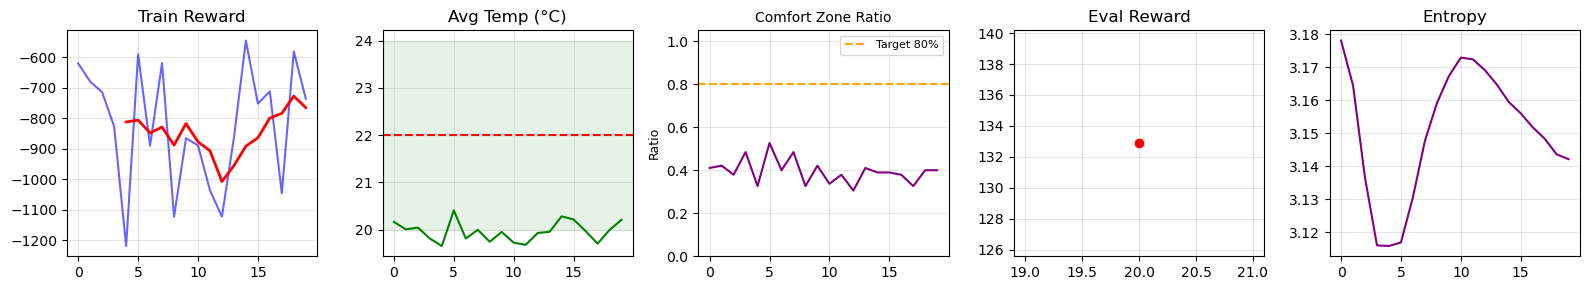

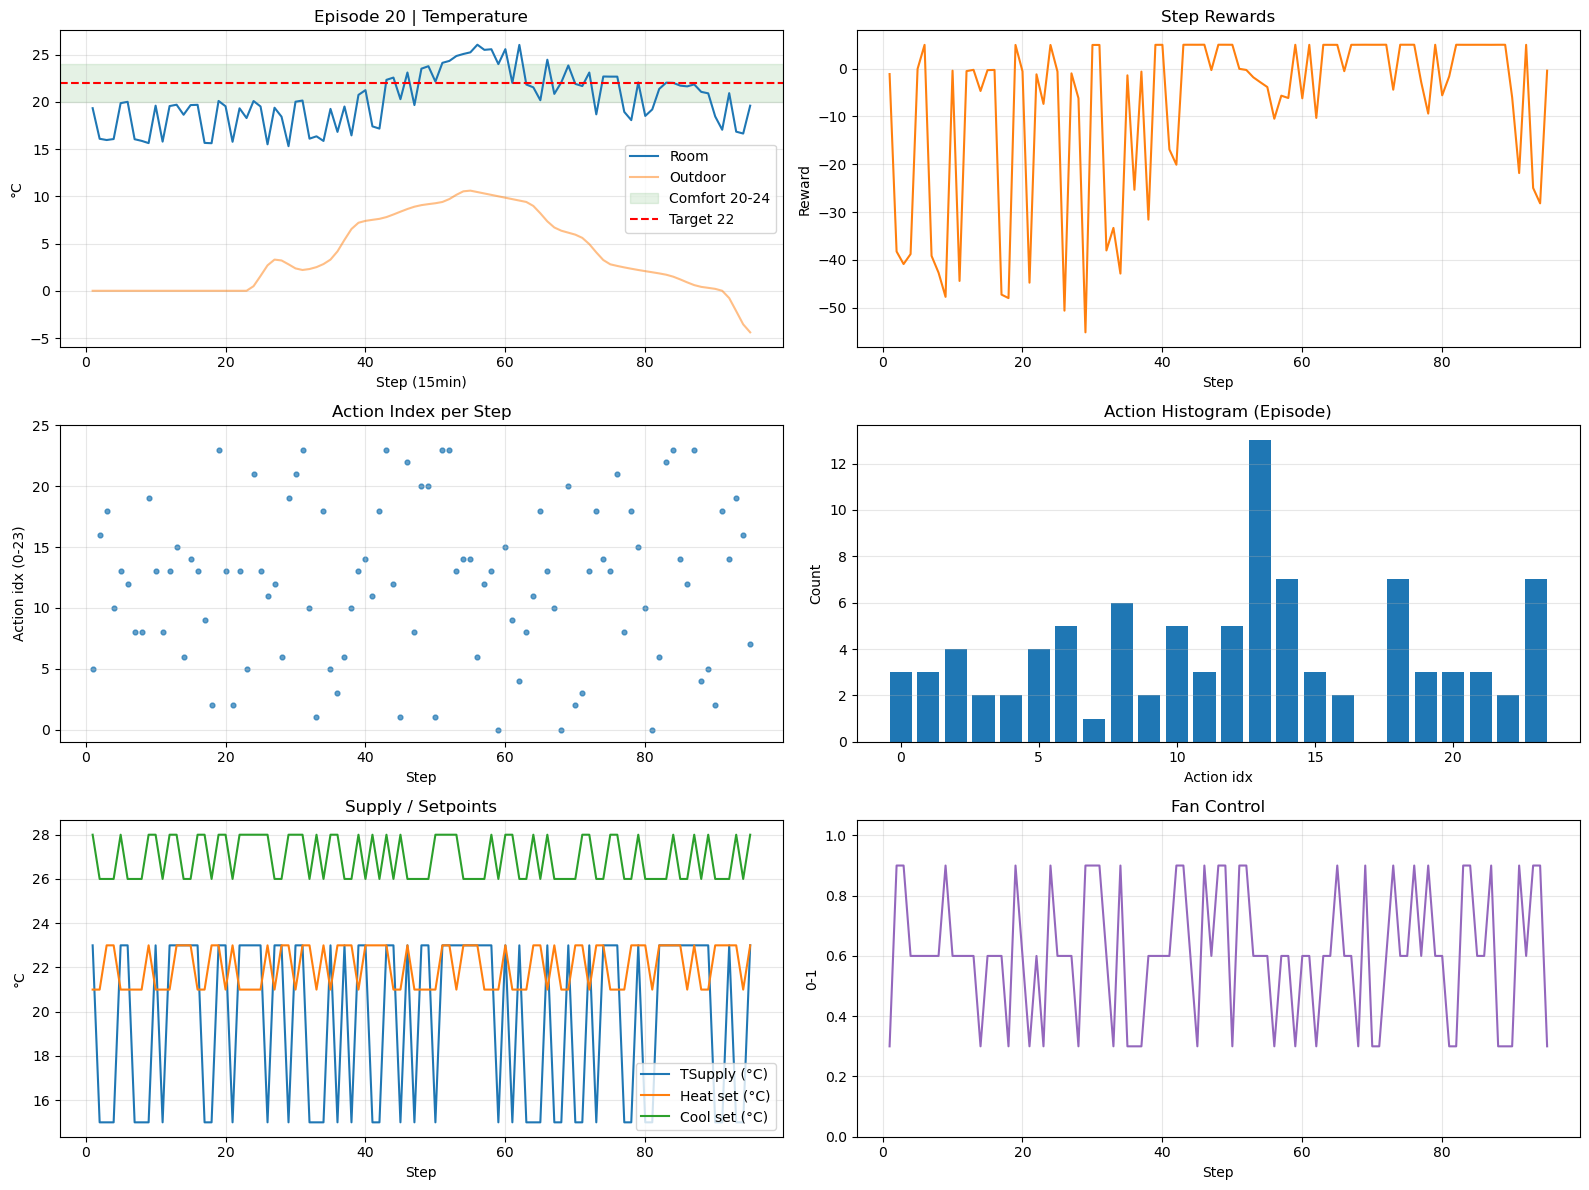


📊 Episode 21/500
[14:48:16] INFO  | 开始重置环境...
[14:48:16] INFO  | 选择测试案例: bestest_air
[14:48:16] INFO  | 尝试选择测试案例 (尝试 1/3)...
[14:48:20] INFO  | ✅ Test ID: 5322c822-5494-41e5-97d5-6d9b4ad9dd56
[14:48:23] INFO  |   → Initialize...
[14:48:24] INFO  |   ✓ Initialize 成功
[14:48:24] INFO  |   → Set step...
[14:48:24] INFO  |   ✓ Set step 成功
[14:48:24] INFO  |   → Advance...
[14:48:24] INFO  | ✅ 环境重置成功
  Step  10 | 室温= 20.6°C | 室外= -0.0°C | R= +4.96 | 动作=23 | Fan=0.9|供风=23°C|热设=23.0°C|冷设=28.0°C
           Top3概率: [A12:0.07, A22:0.06, A7:0.06]
           细分: comfort=+5.00, energy=-0.04, smooth=-0.00
  Step  20 | 室温= 18.3°C | 室外= -0.0°C | R= -7.03 | 动作= 5 | Fan=0.3|供风=23°C|热设=21.0°C|冷设=28.0°C
           Top3概率: [A12:0.07, A22:0.06, A7:0.06]
           细分: comfort=-7.01, energy=-0.01, smooth=-0.00
  Step  30 | 室温= 18.3°C | 室外=  2.4°C | R= -6.91 | 动作= 7 | Fan=0.3|供风=23°C|热设=23.0°C|冷设=28.0°C
           Top3概率: [A12:0.07, A22:0.06, A7:0.06]
           细分: comfort=-6.90, energy=-0.01, smooth=-0.00
 

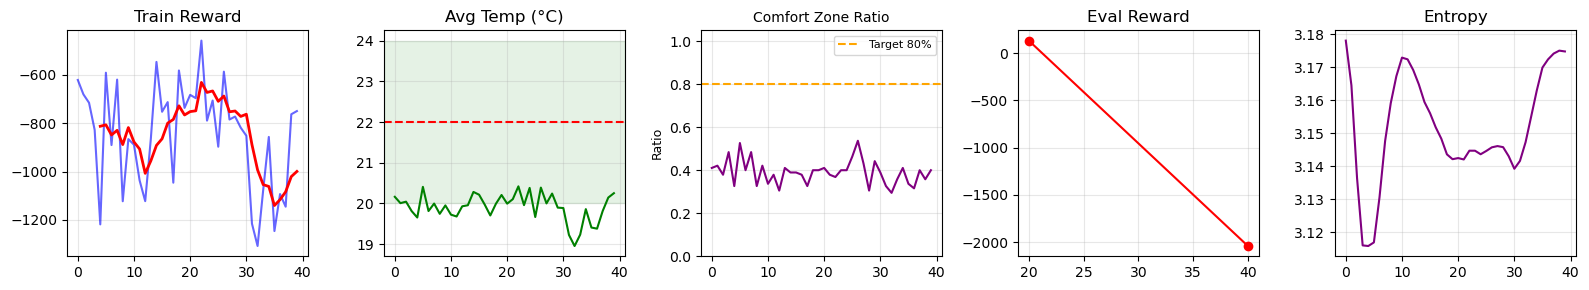

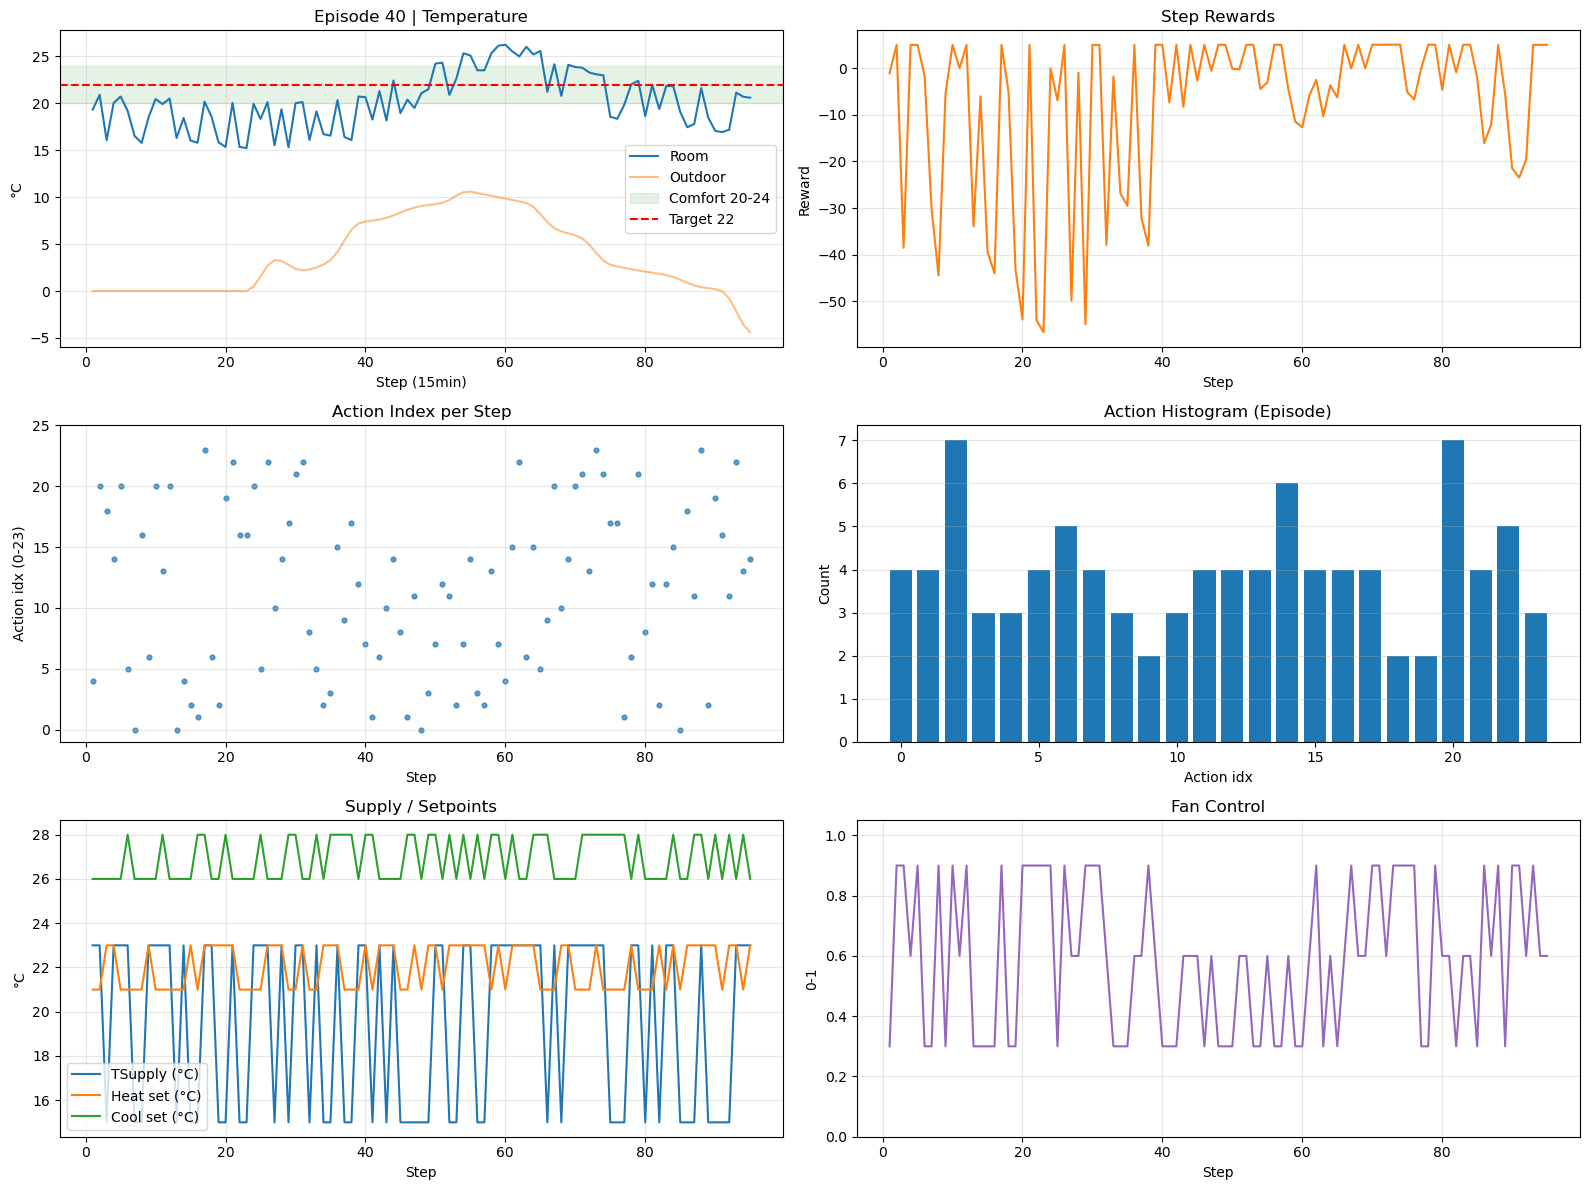


📊 Episode 41/500
[14:49:53] INFO  | 开始重置环境...
[14:49:53] INFO  | 选择测试案例: bestest_air
[14:49:53] INFO  | 尝试选择测试案例 (尝试 1/3)...
[14:49:58] INFO  | ✅ Test ID: 02d65b1f-6809-4bc2-8ea9-ee1261798202
[14:50:01] INFO  |   → Initialize...
[14:50:01] INFO  |   ✓ Initialize 成功
[14:50:01] INFO  |   → Set step...
[14:50:01] INFO  |   ✓ Set step 成功
[14:50:01] INFO  |   → Advance...
[14:50:01] INFO  | ✅ 环境重置成功
  Step  10 | 室温= 15.6°C | 室外= -0.0°C | R=-49.07 | 动作=19 | Fan=0.9|供风=15°C|热设=23.0°C|冷设=28.0°C
           Top3概率: [A2:0.05, A19:0.05, A20:0.05]
           细分: comfort=-49.07, energy=-0.00, smooth=-0.00
  Step  20 | 室温= 15.8°C | 室外= -0.0°C | R=-44.30 | 动作= 3 | Fan=0.3|供风=15°C|热设=23.0°C|冷设=28.0°C
           Top3概率: [A2:0.05, A19:0.05, A20:0.05]
           细分: comfort=-44.30, energy=-0.00, smooth=-0.00
  Step  30 | 室温= 17.7°C | 室外=  2.4°C | R=-12.77 | 动作= 5 | Fan=0.3|供风=23°C|热设=21.0°C|冷设=28.0°C
           Top3概率: [A2:0.05, A19:0.05, A20:0.05]
           细分: comfort=-12.75, energy=-0.01, smooth=-0.0

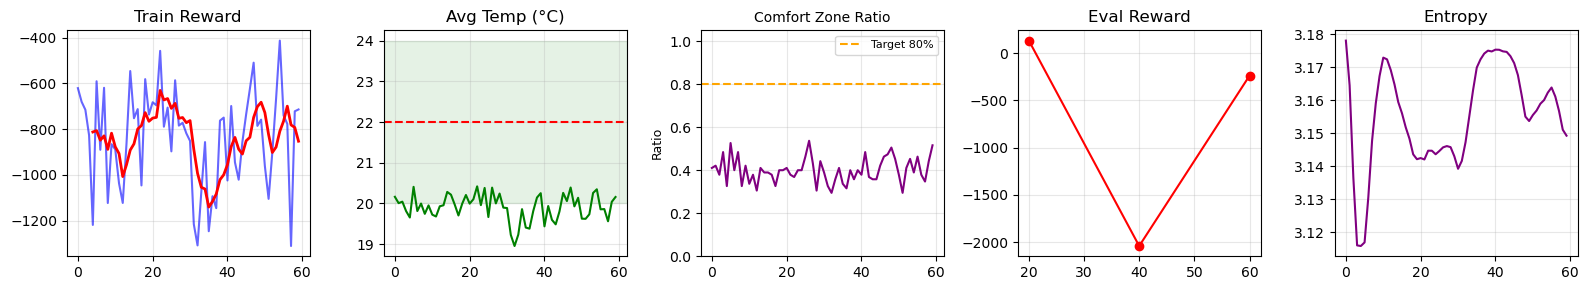

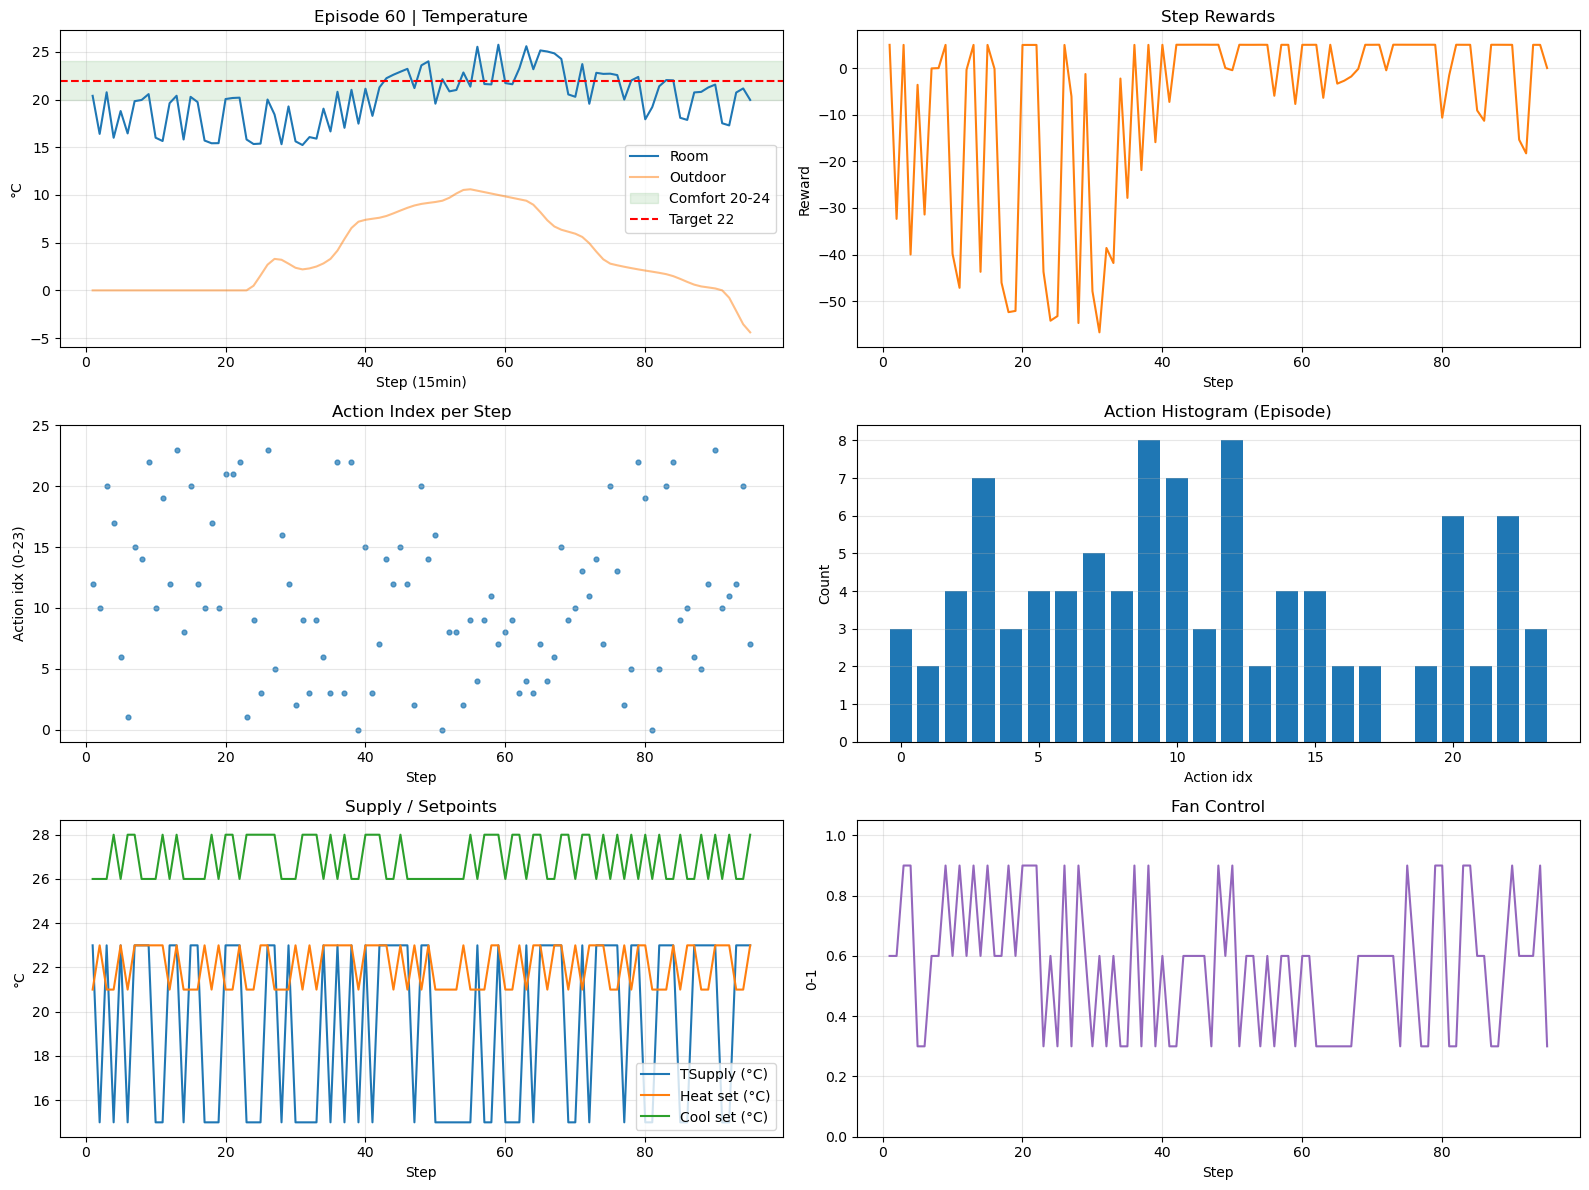


📊 Episode 61/500
[14:51:39] INFO  | 开始重置环境...
[14:51:39] INFO  | 选择测试案例: bestest_air
[14:51:39] INFO  | 尝试选择测试案例 (尝试 1/3)...
[14:51:44] INFO  | ✅ Test ID: b721645f-08a7-4a32-9fbb-85a127be1de4
[14:51:47] INFO  |   → Initialize...
[14:51:48] INFO  |   ✓ Initialize 成功
[14:51:48] INFO  |   → Set step...
[14:51:48] INFO  |   ✓ Set step 成功
[14:51:48] INFO  |   → Advance...
[14:51:48] INFO  | ✅ 环境重置成功
  Step  10 | 室温= 20.4°C | 室外= -0.0°C | R= +4.96 | 动作=22 | Fan=0.9|供风=23°C|热设=23.0°C|冷设=26.0°C
           Top3概率: [A7:0.07, A9:0.06, A8:0.05]
           细分: comfort=+5.00, energy=-0.04, smooth=-0.00
  Step  20 | 室温= 18.0°C | 室外= -0.0°C | R= -9.85 | 动作= 5 | Fan=0.3|供风=23°C|热设=21.0°C|冷设=28.0°C
           Top3概率: [A7:0.07, A9:0.06, A8:0.05]
           细分: comfort=-9.84, energy=-0.01, smooth=-0.00
  Step  30 | 室温= 19.4°C | 室外=  2.4°C | R= -0.92 | 动作=13 | Fan=0.6|供风=23°C|热设=21.0°C|冷设=28.0°C
           Top3概率: [A7:0.07, A9:0.06, A8:0.05]
           细分: comfort=-0.90, energy=-0.02, smooth=-0.00
  Step 

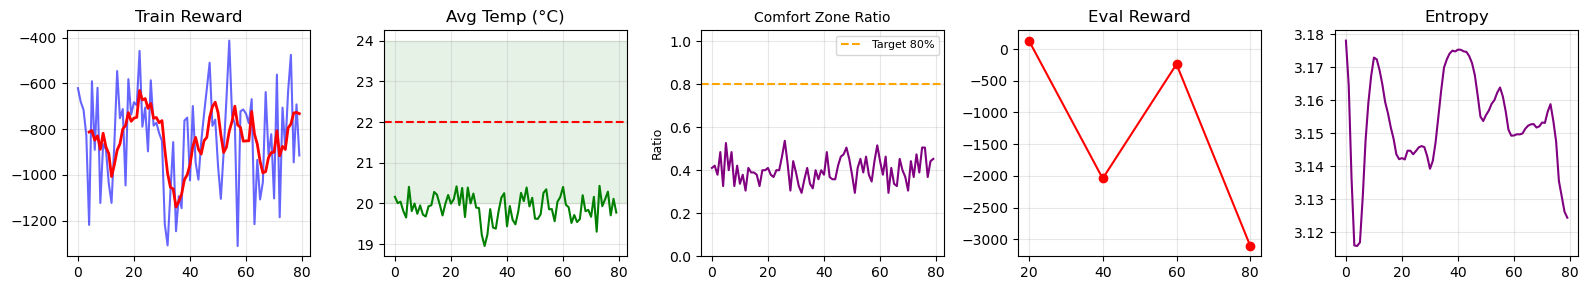

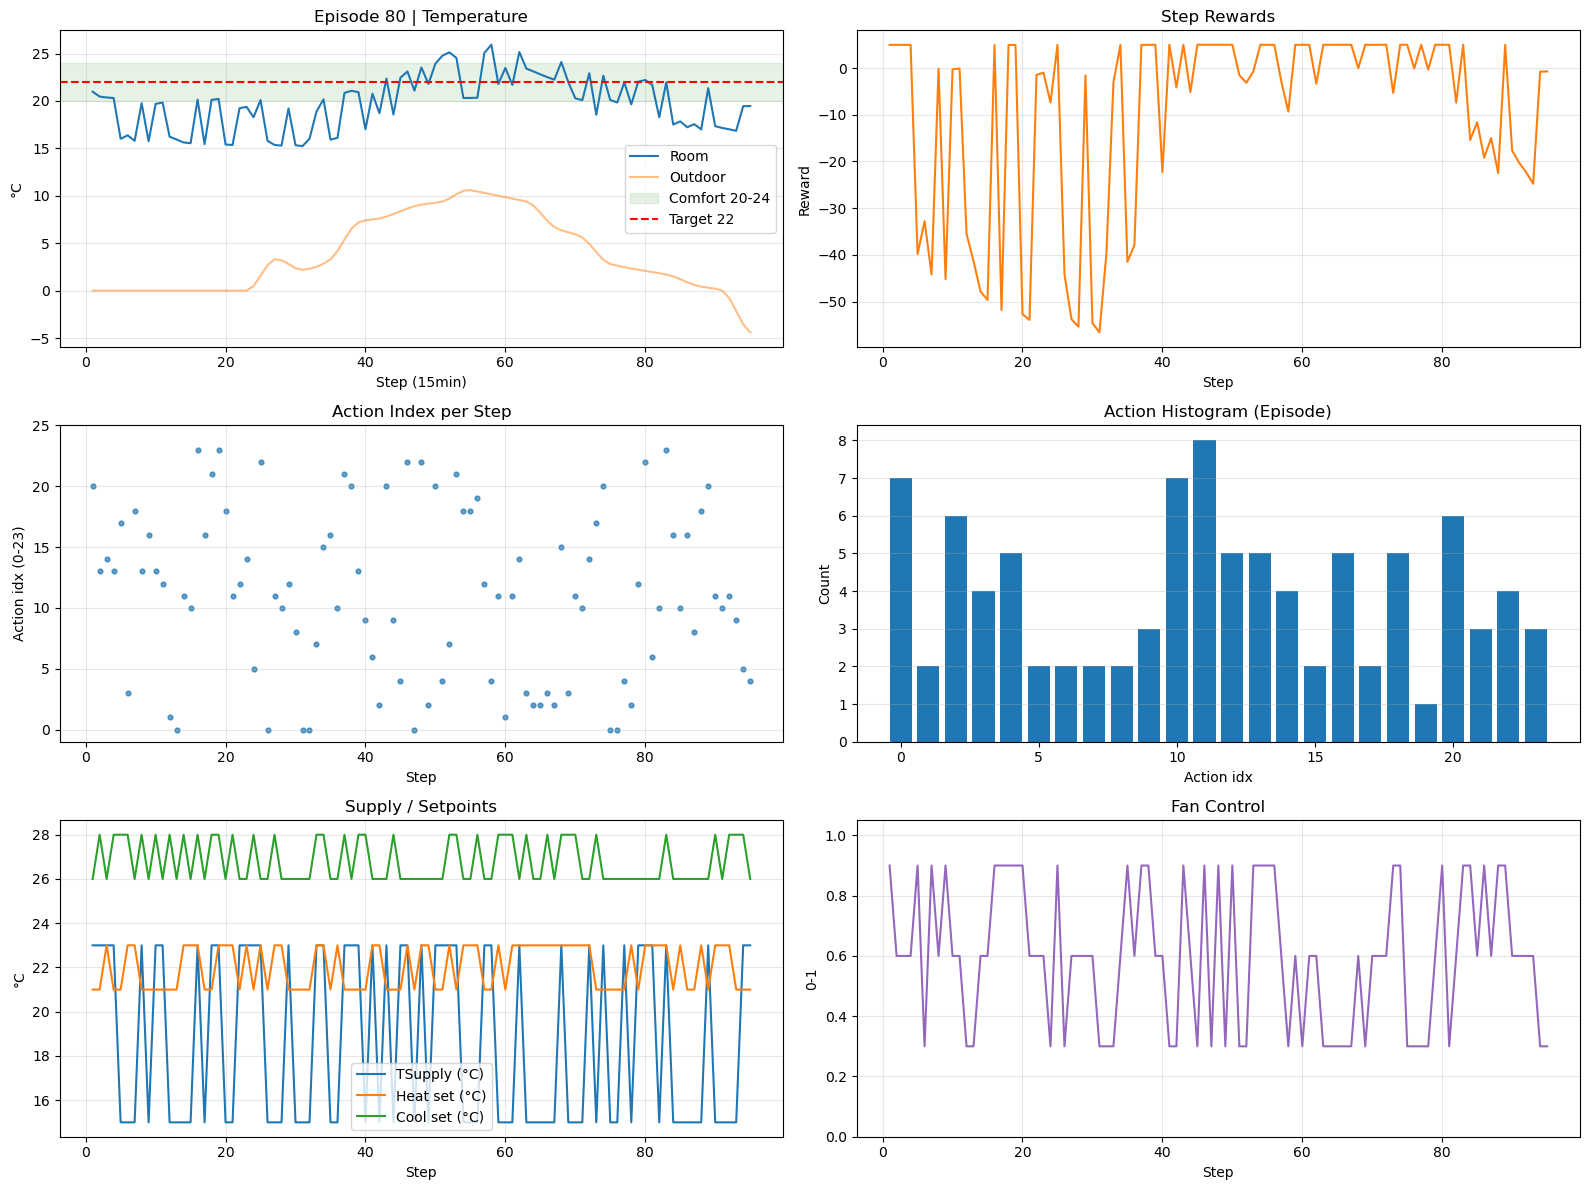


📊 Episode 81/500
[14:53:13] INFO  | 开始重置环境...
[14:53:13] INFO  | 选择测试案例: bestest_air
[14:53:13] INFO  | 尝试选择测试案例 (尝试 1/3)...
[14:53:18] INFO  | ✅ Test ID: 9fd96838-5c53-4237-a637-e385fde6cb3a
[14:53:21] INFO  |   → Initialize...
[14:53:21] INFO  |   ✓ Initialize 成功
[14:53:21] INFO  |   → Set step...
[14:53:21] INFO  |   ✓ Set step 成功
[14:53:21] INFO  |   → Advance...
[14:53:21] INFO  | ✅ 环境重置成功
  Step  10 | 室温= 15.6°C | 室外= -0.0°C | R=-47.31 | 动作=18 | Fan=0.9|供风=15°C|热设=23.0°C|冷设=26.0°C
           Top3概率: [A18:0.09, A20:0.07, A22:0.07]
           细分: comfort=-47.31, energy=-0.00, smooth=-0.00
  Step  20 | 室温= 17.9°C | 室外= -0.0°C | R=-10.78 | 动作= 6 | Fan=0.3|供风=23°C|热设=23.0°C|冷设=26.0°C
           Top3概率: [A18:0.09, A20:0.07, A22:0.07]
           细分: comfort=-10.77, energy=-0.01, smooth=-0.00
  Step  30 | 室温= 15.1°C | 室外=  2.4°C | R=-60.00 | 动作=19 | Fan=0.9|供风=15°C|热设=23.0°C|冷设=28.0°C
           Top3概率: [A18:0.09, A20:0.07, A22:0.07]
           细分: comfort=-60.87, energy=-0.00, smooth=-

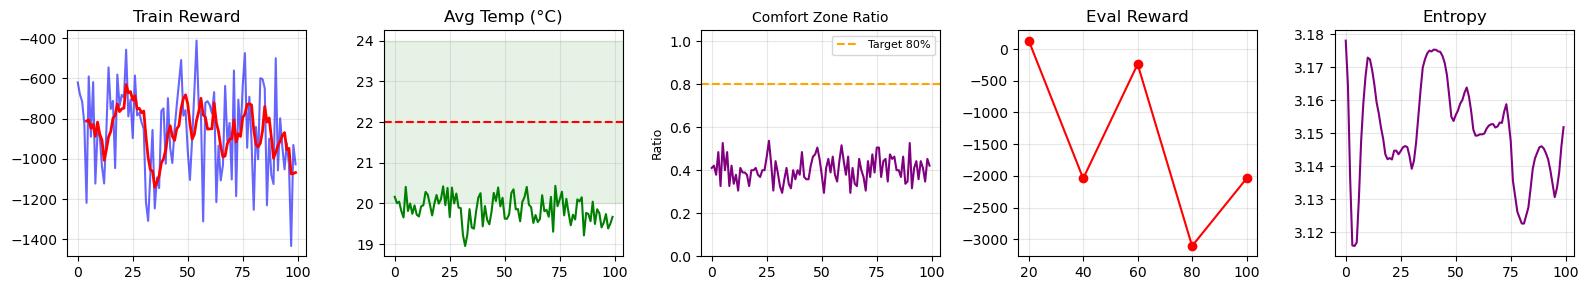

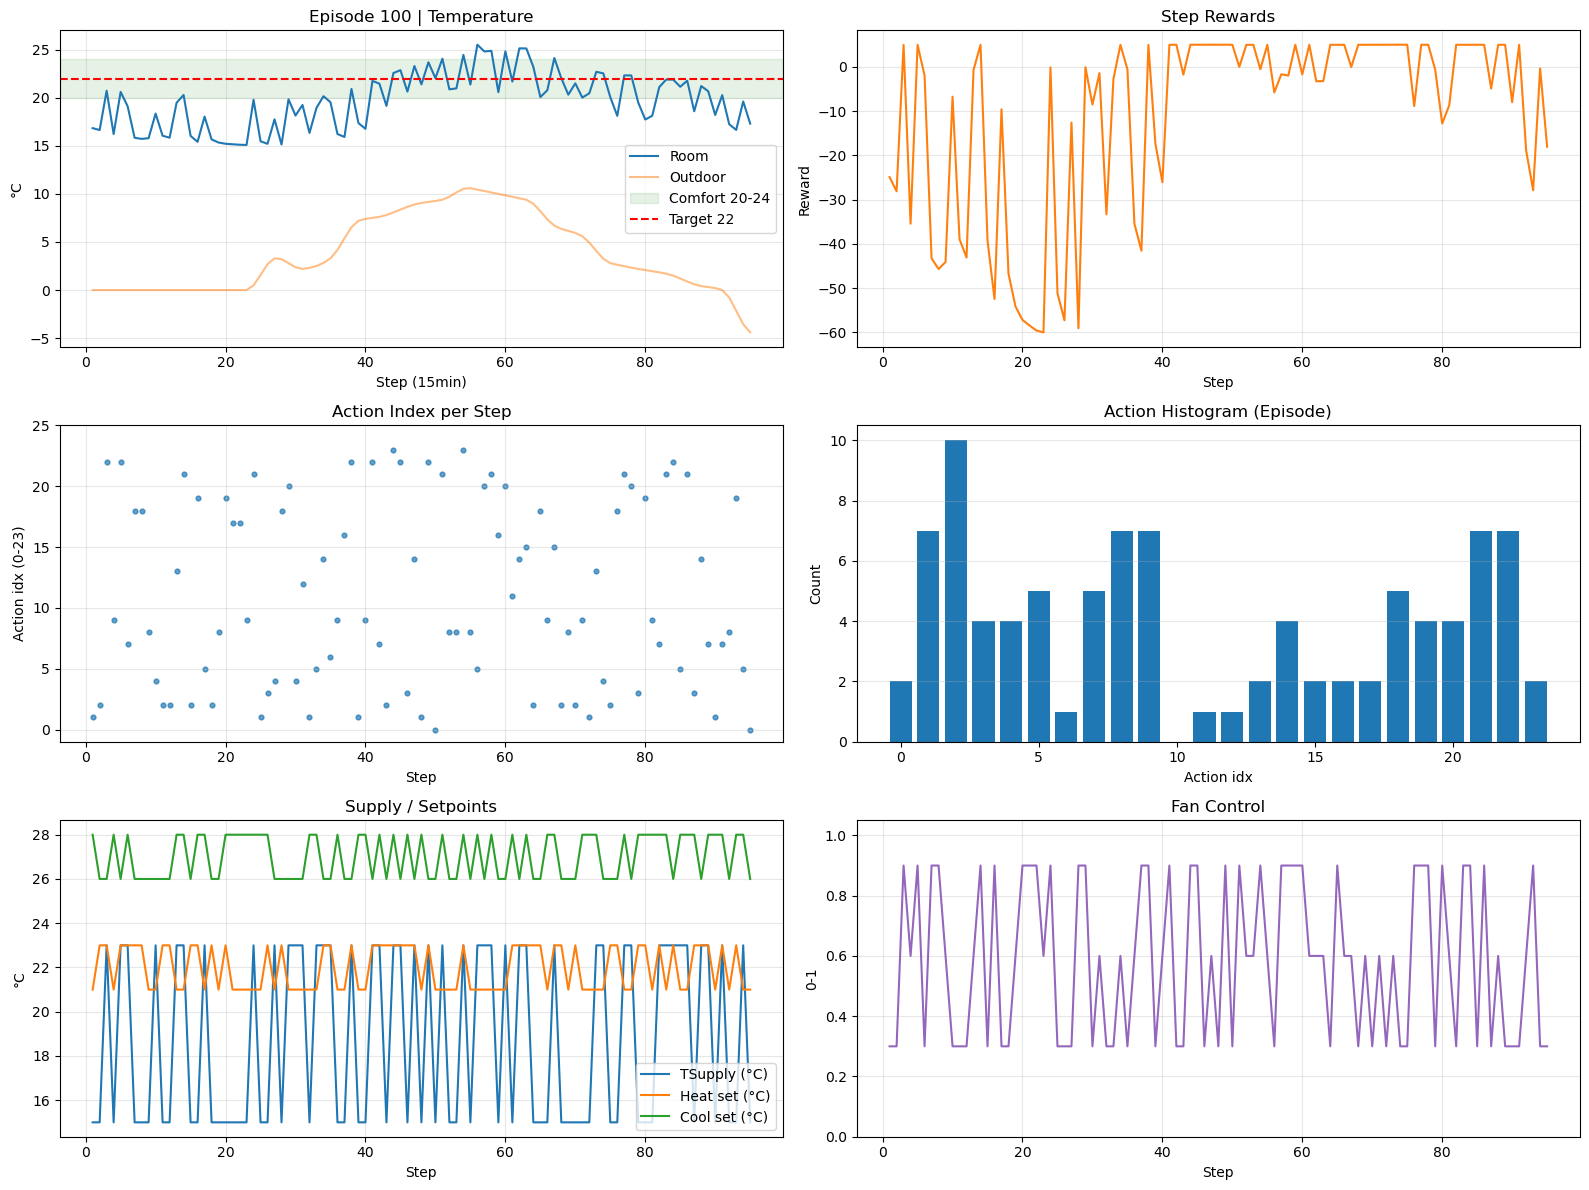


📊 Episode 101/500
[14:54:43] INFO  | 开始重置环境...
[14:54:43] INFO  | 选择测试案例: bestest_air
[14:54:43] INFO  | 尝试选择测试案例 (尝试 1/3)...
[14:54:47] INFO  | ✅ Test ID: ad2d6d36-5174-4428-b4a7-431f0fa29cc6
[14:54:50] INFO  |   → Initialize...
[14:54:51] INFO  |   ✓ Initialize 成功
[14:54:51] INFO  |   → Set step...
[14:54:51] INFO  |   ✓ Set step 成功
[14:54:51] INFO  |   → Advance...
[14:54:51] INFO  | ✅ 环境重置成功
  Step  10 | 室温= 16.2°C | 室外= -0.0°C | R=-36.96 | 动作= 1 | Fan=0.3|供风=15°C|热设=21.0°C|冷设=28.0°C
           Top3概率: [A1:0.06, A3:0.06, A16:0.05]
           细分: comfort=-36.96, energy=-0.00, smooth=-0.00
  Step  20 | 室温= 20.3°C | 室外= -0.0°C | R= +4.95 | 动作=22 | Fan=0.9|供风=23°C|热设=23.0°C|冷设=26.0°C
           Top3概率: [A1:0.06, A3:0.06, A16:0.05]
           细分: comfort=+5.00, energy=-0.05, smooth=-0.00
  Step  30 | 室温= 15.5°C | 室外=  2.4°C | R=-50.72 | 动作= 1 | Fan=0.3|供风=15°C|热设=21.0°C|冷设=28.0°C
           Top3概率: [A1:0.06, A3:0.06, A16:0.05]
           细分: comfort=-50.72, energy=-0.00, smooth=-0.00
 

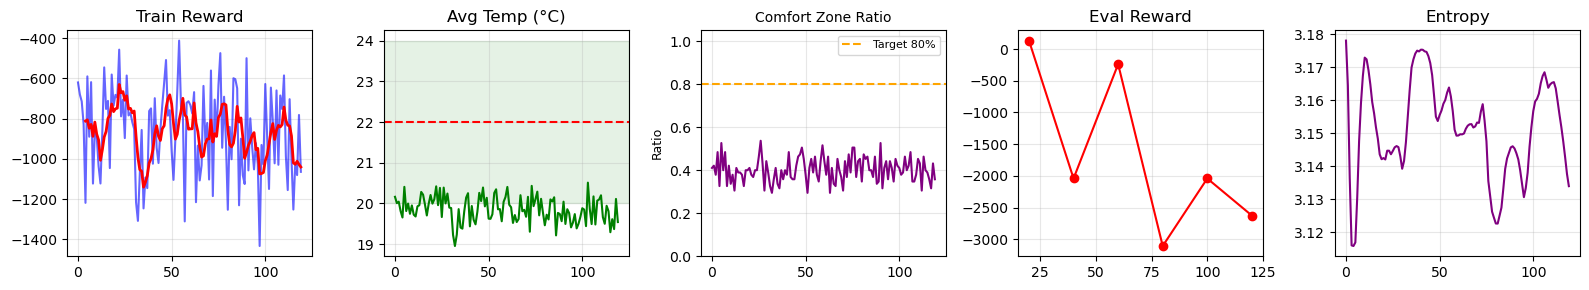

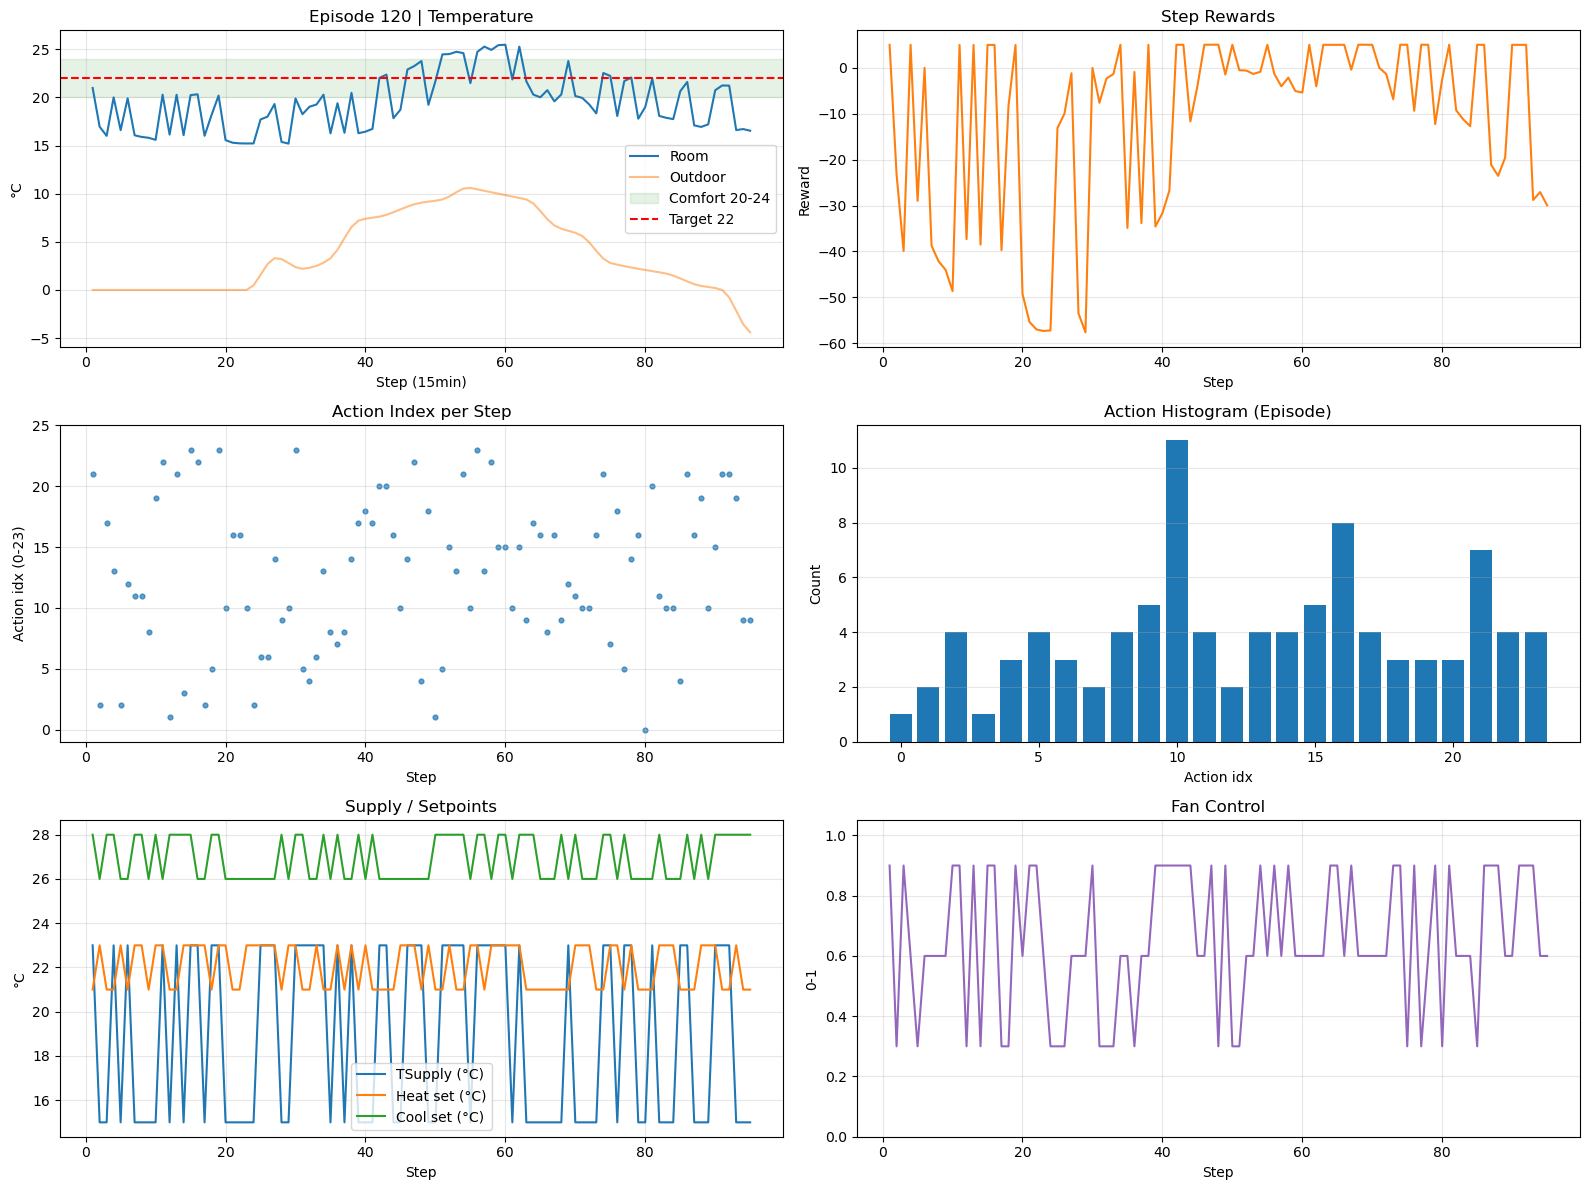


📊 Episode 121/500
[14:56:10] INFO  | 开始重置环境...
[14:56:10] INFO  | 选择测试案例: bestest_air
[14:56:10] INFO  | 尝试选择测试案例 (尝试 1/3)...
[14:56:14] INFO  | ✅ Test ID: 6bbed7dd-83ec-4df3-bb22-b9dd7309a74f
[14:56:17] INFO  |   → Initialize...
[14:56:18] INFO  |   ✓ Initialize 成功
[14:56:18] INFO  |   → Set step...
[14:56:18] INFO  |   ✓ Set step 成功
[14:56:18] INFO  |   → Advance...
[14:56:18] INFO  | ✅ 环境重置成功
  Step  10 | 室温= 15.8°C | 室外= -0.0°C | R=-43.40 | 动作=19 | Fan=0.9|供风=15°C|热设=23.0°C|冷设=28.0°C
           Top3概率: [A10:0.09, A18:0.06, A21:0.06]
           细分: comfort=-43.40, energy=-0.00, smooth=-0.00
  Step  20 | 室温= 15.7°C | 室外= -0.0°C | R=-46.84 | 动作= 1 | Fan=0.3|供风=15°C|热设=21.0°C|冷设=28.0°C
           Top3概率: [A10:0.09, A18:0.06, A21:0.06]
           细分: comfort=-46.84, energy=-0.00, smooth=-0.00
  Step  30 | 室温= 15.2°C | 室外=  2.4°C | R=-58.80 | 动作=18 | Fan=0.9|供风=15°C|热设=23.0°C|冷设=26.0°C
           Top3概率: [A10:0.09, A18:0.06, A21:0.06]
           细分: comfort=-58.80, energy=-0.00, smooth=

In [ ]:
train()